# Petbreed Multiclassification - Wayde

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

In [3]:
torch.cuda.set_device(0)
print(f'Using GPU#{torch.cuda.current_device()}')

Using GPU#0


## Configuration

In [4]:
PATH = Path('data')
TRAIN = PATH/'train'
TEST = PATH/'test'

In [27]:
# Scaling --> Change as needed
bs,sz = 16,350
# bs = 16

prefix = "highres_"

## Data Prep

In [28]:
PATH.ls()

[PosixPath('data/train.csv'),
 PosixPath('data/sampleSubmission_breed.csv'),
 PosixPath('data/models'),
 PosixPath('data/large'),
 PosixPath('data/ucsd-2019-datathon.zip'),
 PosixPath('data/train'),
 PosixPath('data/test'),
 PosixPath('data/image.zip')]

In [7]:
# ?get_image_files

In [8]:
train_df = pd.read_csv(PATH/'train.csv', engine='python')
train_df.head()

,breedID,speciesID,fname,breed_name
0,23,2,0,newfoundland
1,35,2,1,staffordshire bull terrier
2,19,2,2,keeshond
3,2,2,3,american bulldog
4,29,2,4,saint bernard


### Upsampling

In [11]:
LARGE = PATH/'large'
LARGE.mkdir(exist_ok=True)

In [ ]:
%%time
amt = os.listdir(TRAIN)
amt_len = len(amt)
mult_amt = 10
i = 1

while i < mult_amt:
    n = 0
    while n < amt_len:
        amt.append(amt[n][:-4] + '_copy_' + str(i) + '.jpg')
        os.system(f'cp {TRAIN}/{amt[n]} {LARGE}/{amt[n][:-4]}_copy_{str(i)}.jpg')
        n+=1
    i+=1

### Datablock

In [9]:
str(LARGE.ls()[0]).split(sep='/')[1]

NameError: name 'LARGE' is not defined

In [10]:
str(LARGE.ls()[0]).split(sep='/')[-1][:-11]

NameError: name 'LARGE' is not defined

In [29]:
# Labeling function used by Datablock API
def get_labels(fname):    
    fname = str(fname) # Convert path object to string
    fname = fname.split(sep='/')
    
    if fname[1] == "train":
        fname = fname[len(fname) - 1]
        fname = fname[:-4]

        row = train_df.loc[train_df['fname'] == int(fname)]
        label = row["breed_name"].values[0]
        
#     if fname[1] == "large":
#         fname = fname[len(fname) - 1]
#         fname = fname[:-11]

#         row = train_df.loc[train_df['fname'] == int(fname)]
#         label = row["breed_name"].values[0]
        
    return label

**Fastai Base Transforms**

``get_transforms()``

Utility func to easily create a list of flip, rotate, zoom, warp, lighting transforms.

- do_flip: if True, a random flip is applied with probability 0.5
- flip_vert: requires do_flip=True. If True, the image can be flipped vertically or rotated of 90 degrees, otherwise only an h orizontal flip is applied
- max_rotate: if not None, a random rotation between -max_rotate and max_rotate degrees is applied with probability p_affine
- max_zoom: if not 1. or less, a random zoom betweem 1. and max_zoom is applied with probability p_affine
- max_lighting: if not None, a random lightning and contrast change controlled by max_lighting is applied with probability p_lighting
- max_warp: if not None, a random symmetric warp of magnitude between -max_warp and maw_warp is applied with probability p_affine
- p_affine: the probability that each affine transform and symmetric warp is applied
- p_lighting: the probability that each lighting transform is applied
- xtra_tfms: a list of additional transforms you would like to be applied

In [30]:
# Datablock
data = (ImageList.from_folder(TRAIN) # Change to "TRAIN" or "LARGE" as needed
        .split_by_rand_pct()
        .label_from_func(get_labels)
        .transform(get_transforms(), size=sz)
        .databunch(bs=bs).normalize(imagenet_stats))

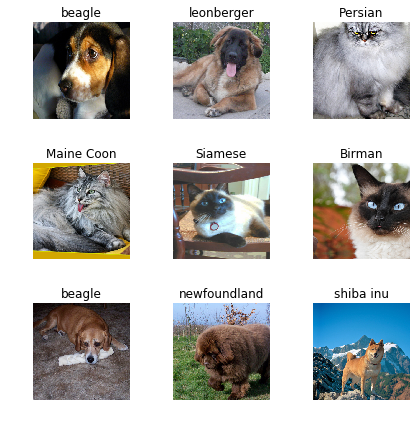

In [31]:
data.show_batch(rows=3, figsize=(6,6))

In [12]:
len(os.listdir(LARGE))

NameError: name 'LARGE' is not defined

In [ ]:
print(data.classes)

## Modeling

In [32]:
gc.collect()

18213

In [33]:
learn = cnn_learner(data, models.resnet50, metrics=(error_rate,accuracy))

In [34]:
learn.path = PATH
os.system(f"mv {TRAIN}/models {PATH}")

256

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


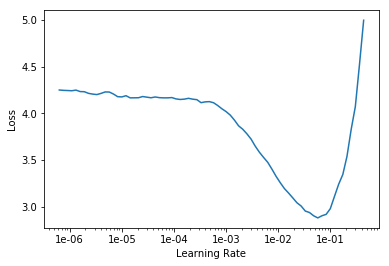

In [35]:
learn.lr_find()
learn.recorder.plot()

In [36]:
lr = 1e-2

In [ ]:
learn.fit_one_cycle(15, slice(lr))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.810431,0.311167,0.092391,0.907609,00:34
1,0.609250,0.313049,0.107337,0.892663,00:34
2,0.694623,0.553596,0.149457,0.850543,00:35
3,0.660849,0.533634,0.120924,0.879076,00:34


In [20]:
learn.save(f"{prefix}first")

In [21]:
learn.load(f"{prefix}first");

In [22]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


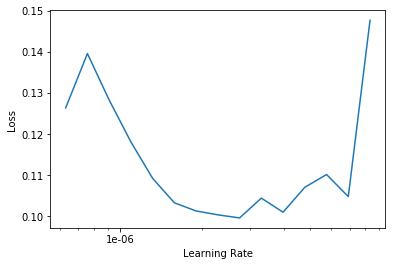

In [24]:
learn.lr_find()
learn.recorder.plot()

In [25]:
learn.fit_one_cycle(5, max_lr=slice(5e-6,5e-5))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.093927,0.265448,0.067935,0.932065,00:25
1,0.092240,0.271379,0.069293,0.930707,00:25
2,0.106744,0.274170,0.067935,0.932065,00:25
3,0.095141,0.254900,0.058424,0.941576,00:25
4,0.076692,0.257743,0.059783,0.940217,00:25


In [26]:
learn.save(f"{prefix}second")